Training results length: 3285
Original inference results length: 3285
Retrained inference results length: 3285


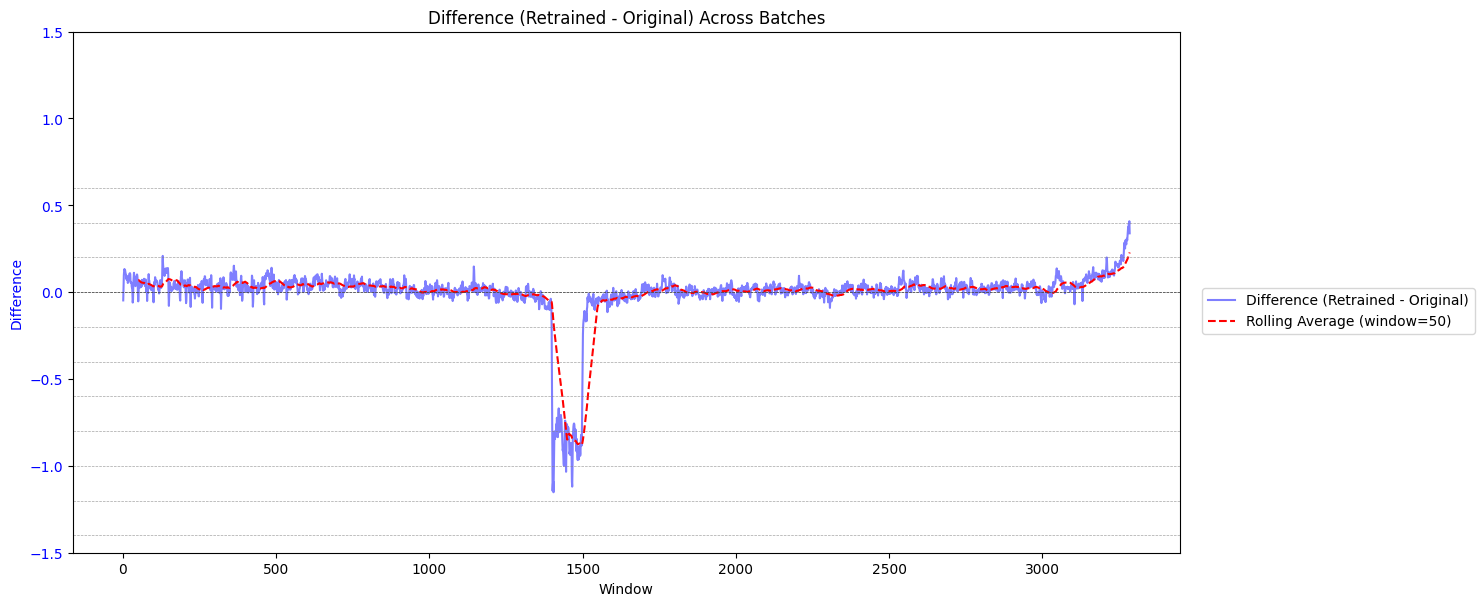

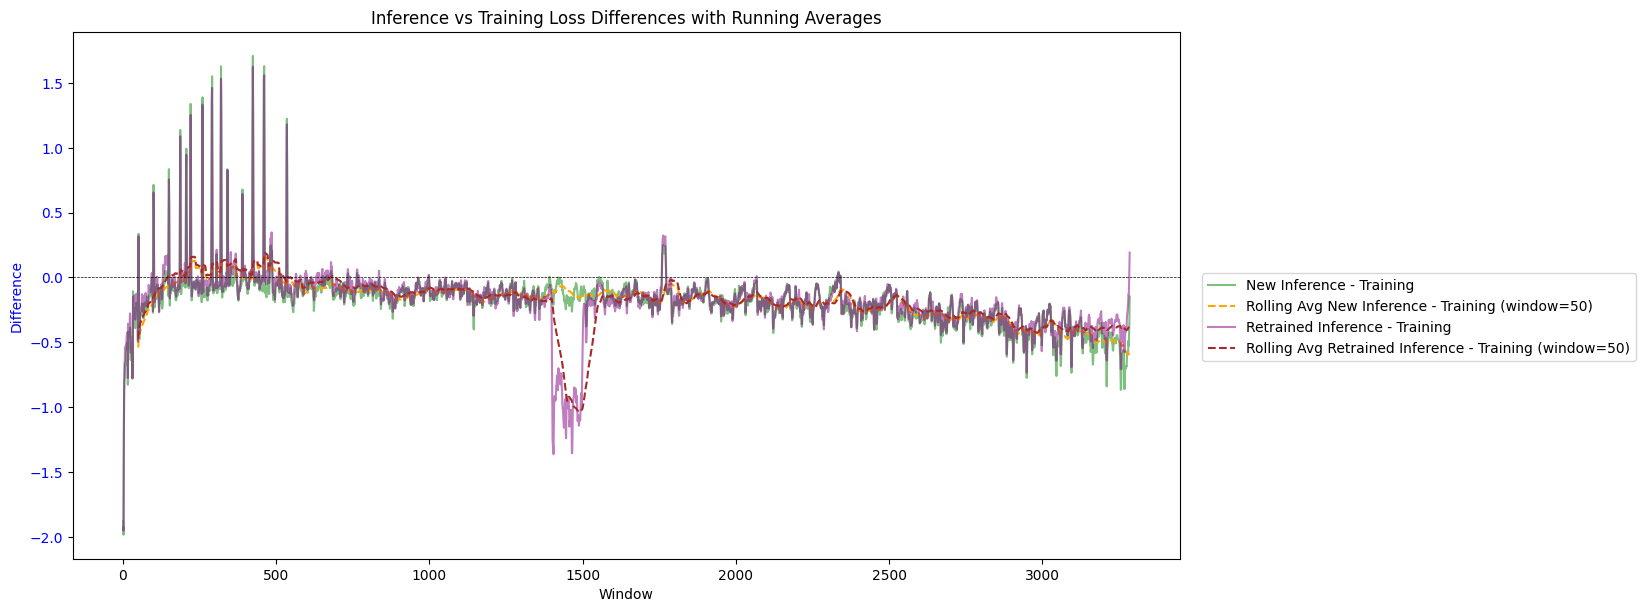

Analysis completed. Plots saved in: experiments/rolling_window_2/retrain_1400_1500


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Configuration variables
EXPERIMENT_NAME = 'rolling_window_2'  # Set your experiment name here
EXPERIMENT_DIR = os.path.join('experiments', EXPERIMENT_NAME)
RETRAIN_DIR = os.path.join(EXPERIMENT_DIR, 'retrain_1400_1500')
TRAINING_RESULTS_PATH = os.path.join(EXPERIMENT_DIR, "training_loss.csv")
INFERENCE_RESULTS_PATH = os.path.join(RETRAIN_DIR, "retrained_inference_results.csv")
ORIGINAL_INFERENCE_RESULTS_PATH = os.path.join('/workspace/slice-monorepo/sub_validations/cl_scaling/dnd/experiments/rolling_window_2', 'new_inference_results.csv')

ROLLING_WINDOW = 50  # Rolling window size for smoothing
MAX_Y_DIFF = 1.5  # Maximum y-axis limit for the difference plot

def plot_difference(inference_results, retrained_results, save_dir, rolling_window, max_y_diff):
    df_infer = pd.DataFrame(inference_results)
    df_retrain = pd.DataFrame(retrained_results)

    # Merge dataframes on 'window' column to ensure alignment
    merged_df = pd.merge(df_infer, df_retrain, on='window', suffixes=('_infer', '_retrain'))

    # Calculate differences and rolling average
    differences = merged_df['inference_loss_retrain'] - merged_df['inference_loss_infer']
    rolling_avg_diff = differences.rolling(window=rolling_window).mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting the differences and rolling average
    ax1.plot(merged_df['window'], differences, label='Difference (Retrained - Original)', color='blue', alpha=0.5)
    ax1.plot(merged_df['window'], rolling_avg_diff, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero

    # Add horizontal lines for each y-axis tick mark
    for y in ax1.get_yticks():
        ax1.axhline(y, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)

    ax1.set_xlabel('Window')
    ax1.set_ylabel('Difference', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(-max_y_diff, max_y_diff)  # Set y-axis limits for differences

    fig.tight_layout()
    plt.title('Difference (Retrained - Original) Across Batches')
    
    # Move the legend to the right of the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'difference_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def plot_inference_vs_training(inference_results, retrained_results, training_results, save_dir, rolling_window):
    df_infer = pd.DataFrame(inference_results)
    df_retrain = pd.DataFrame(retrained_results)
    df_training = pd.DataFrame(training_results)

    # Merge dataframes on 'window' column to ensure alignment
    merged_df = pd.merge(pd.merge(df_infer, df_retrain, on='window', suffixes=('_infer', '_retrain')), df_training, on='window')

    # Calculate differences and rolling average for new_inference_results - training_loss
    new_infer_vs_training = merged_df['inference_loss_infer'] - merged_df['loss']
    retrain_vs_training = merged_df['inference_loss_retrain'] - merged_df['loss']
    rolling_avg_new_infer_vs_training = new_infer_vs_training.rolling(window=rolling_window).mean()
    rolling_avg_retrain_vs_training = retrain_vs_training.rolling(window=rolling_window).mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # New overlaid plot
    ax1.plot(merged_df['window'], new_infer_vs_training, label='New Inference - Training', color='green', alpha=0.5)
    ax1.plot(merged_df['window'], rolling_avg_new_infer_vs_training, label=f'Rolling Avg New Inference - Training (window={rolling_window})', linestyle='--', color='orange')

    ax1.plot(merged_df['window'], retrain_vs_training, label='Retrained Inference - Training', color='purple', alpha=0.5)
    ax1.plot(merged_df['window'], rolling_avg_retrain_vs_training, label=f'Rolling Avg Retrained Inference - Training (window={rolling_window})', linestyle='--', color='brown')

    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero

    ax1.set_xlabel('Window')
    ax1.set_ylabel('Difference', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    fig.tight_layout()
    plt.title('Inference vs Training Loss Differences with Running Averages')
    
    # Move the legend to the right of the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'inference_vs_training_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def main():
    if not os.path.exists(TRAINING_RESULTS_PATH):
        raise FileNotFoundError(f"Training results CSV file not found at {TRAINING_RESULTS_PATH}")

    if not os.path.exists(INFERENCE_RESULTS_PATH):
        raise FileNotFoundError(f"Inference results CSV file not found at {INFERENCE_RESULTS_PATH}")

    if not os.path.exists(ORIGINAL_INFERENCE_RESULTS_PATH):
        raise FileNotFoundError(f"Original inference results CSV file not found at {ORIGINAL_INFERENCE_RESULTS_PATH}")

    # Load data
    training_results = pd.read_csv(TRAINING_RESULTS_PATH)
    original_inference_results = pd.read_csv(ORIGINAL_INFERENCE_RESULTS_PATH)
    retrained_inference_results = pd.read_csv(INFERENCE_RESULTS_PATH)

    print(f"Training results length: {len(training_results)}")
    print(f"Original inference results length: {len(original_inference_results)}")
    print(f"Retrained inference results length: {len(retrained_inference_results)}")

    # Plot difference between retrained and original inference results
    plot_difference(original_inference_results, retrained_inference_results, RETRAIN_DIR, ROLLING_WINDOW, MAX_Y_DIFF)

    # Plot inference vs training differences
    plot_inference_vs_training(original_inference_results, retrained_inference_results, training_results, RETRAIN_DIR, ROLLING_WINDOW)

    print(f"Analysis completed. Plots saved in: {RETRAIN_DIR}")

if __name__ == "__main__":
    main()


Training results length: 9845
Inference results length: 9845


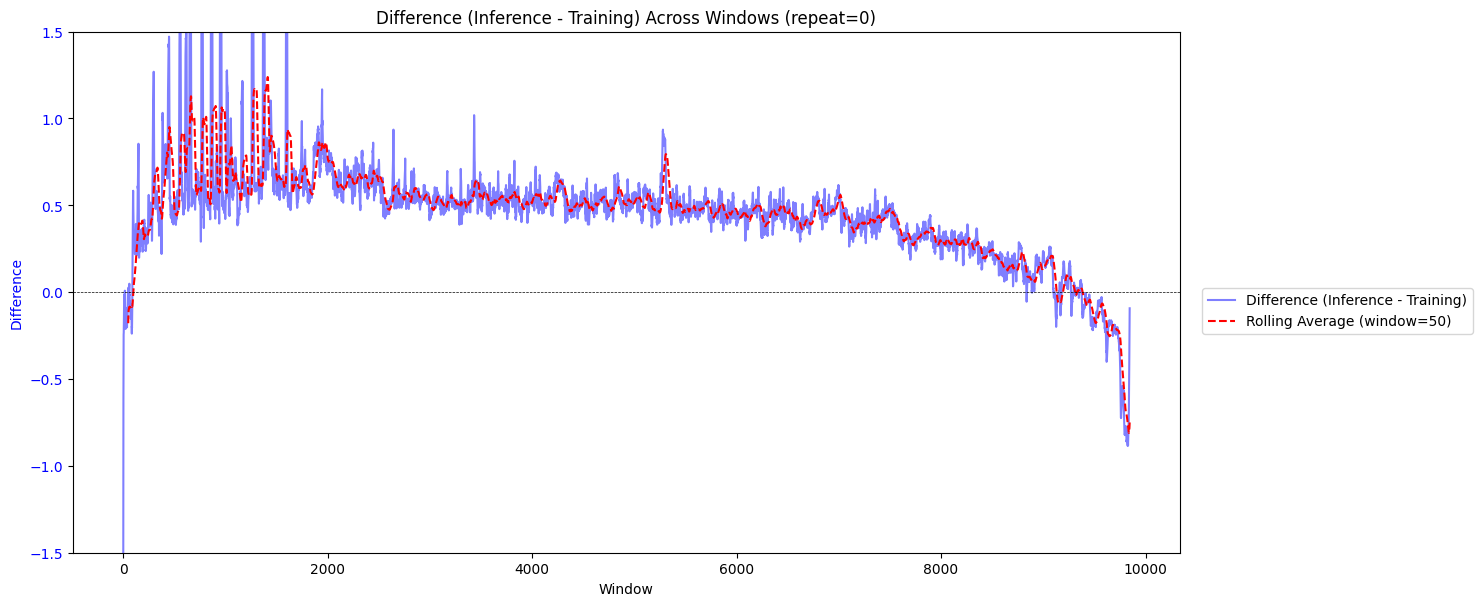

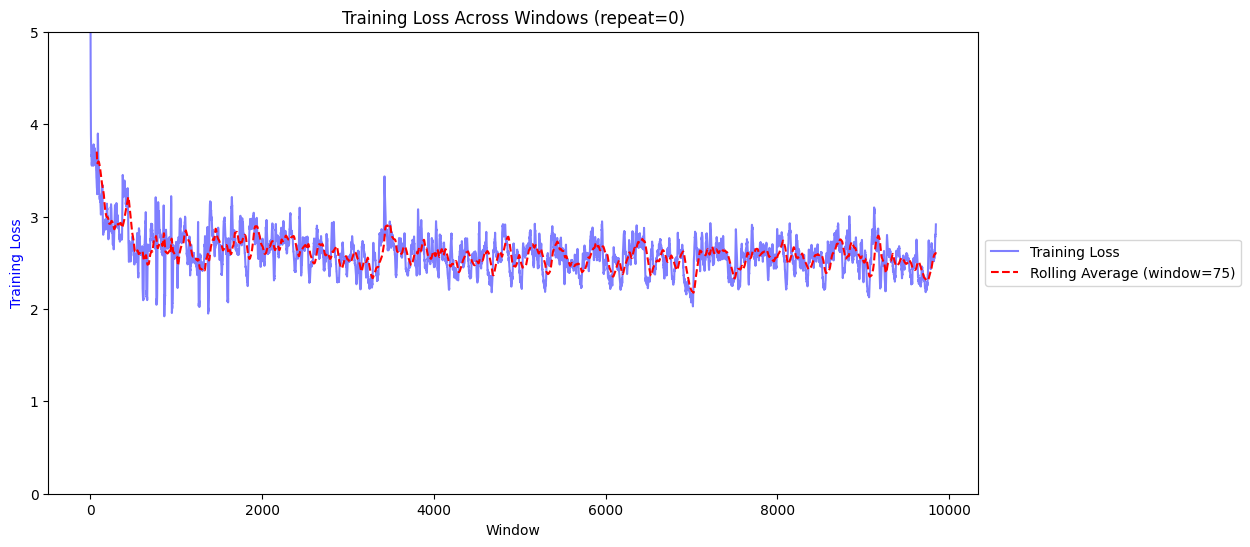

Analysis completed. Plots saved in: experiments/rw_4


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_config(config_path):
    with open(config_path, 'r') as cfg_file:
        return json.load(cfg_file)

def plot_difference(training_results, inference_results, save_dir, rolling_window, max_y_diff, repeat_value):
    df_train = pd.DataFrame(training_results)
    df_infer = pd.DataFrame(inference_results)

    # Calculate differences and rolling average
    differences = df_infer['inference_loss'] - df_train['loss']
    rolling_avg_diff = differences.rolling(window=rolling_window).mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting the differences and rolling average
    ax1.plot(df_train['window'], differences, label='Difference (Inference - Training)', color='blue', alpha=0.5)
    ax1.plot(df_train['window'], rolling_avg_diff, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero
    ax1.set_xlabel('Window')
    ax1.set_ylabel('Difference', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(-max_y_diff, max_y_diff)  # Set y-axis limits for differences

    fig.tight_layout()
    plt.title(f'Difference (Inference - Training) Across Windows (repeat={repeat_value})')
    
    # Move the legend to the right of the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'difference_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def plot_training_loss(training_results, save_dir, rolling_window, max_y_diff, repeat_value):
    df_train = pd.DataFrame(training_results)
    
    # Calculate rolling average of training loss
    rolling_avg_train_loss = df_train['loss'].rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_train['window'], df_train['loss'], label='Training Loss', color='blue', alpha=0.5)
    plt.plot(df_train['window'], rolling_avg_train_loss, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero
    plt.xlabel('Window')
    plt.ylabel('Training Loss', color='blue')
    plt.ylim(0, max_y_diff)  # Set maximum y-axis value for training loss
    plt.title(f'Training Loss Across Windows (repeat={repeat_value})')
    
    # Move the legend to the right of the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'training_loss_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def main():
    config_path = 'rolling_window_config.json'
    cfg = load_config(config_path)
    experiment_name = cfg['experiment_name']
    experiment_dir = os.path.join('experiments', experiment_name)

    results_path = os.path.join(experiment_dir, "training_loss.csv")
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results CSV file not found at {results_path}")

    inference_results_path = os.path.join(experiment_dir, "new_inference_results.csv")
    if not os.path.exists(inference_results_path):
        raise FileNotFoundError(f"Inference results CSV file not found at {inference_results_path}")

    # Load training and inference results
    training_results = pd.read_csv(results_path).to_dict(orient='records')
    inference_results = pd.read_csv(inference_results_path).to_dict(orient='records')

    rolling_window_abs = cfg.get('rolling_window_abs', 50)  # default to 500 if not specified in config
    rolling_window_train = cfg.get('rolling_window_train', 75)  # default to 75 if not specified in config
    max_y_diff_abs = cfg.get('max_y_diff_abs', 1.5)  # default to 0.03 if not specified in config
    max_y_diff_train = cfg.get('max_y_diff_train', 5)  # default to 0.5 if not specified in config

    print(f"Training results length: {len(training_results)}")
    print(f"Inference results length: {len(inference_results)}")

    plot_difference(training_results, inference_results, experiment_dir, rolling_window_abs, max_y_diff_abs, 0)
    plot_training_loss(training_results, experiment_dir, rolling_window_train, max_y_diff_train, 0)

    print(f"Analysis completed. Plots saved in: {experiment_dir}")

if __name__ == "__main__":
    main()


In [2]:
!pip install -q matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


Filtered training results length: 9853
Inference results length: 2000


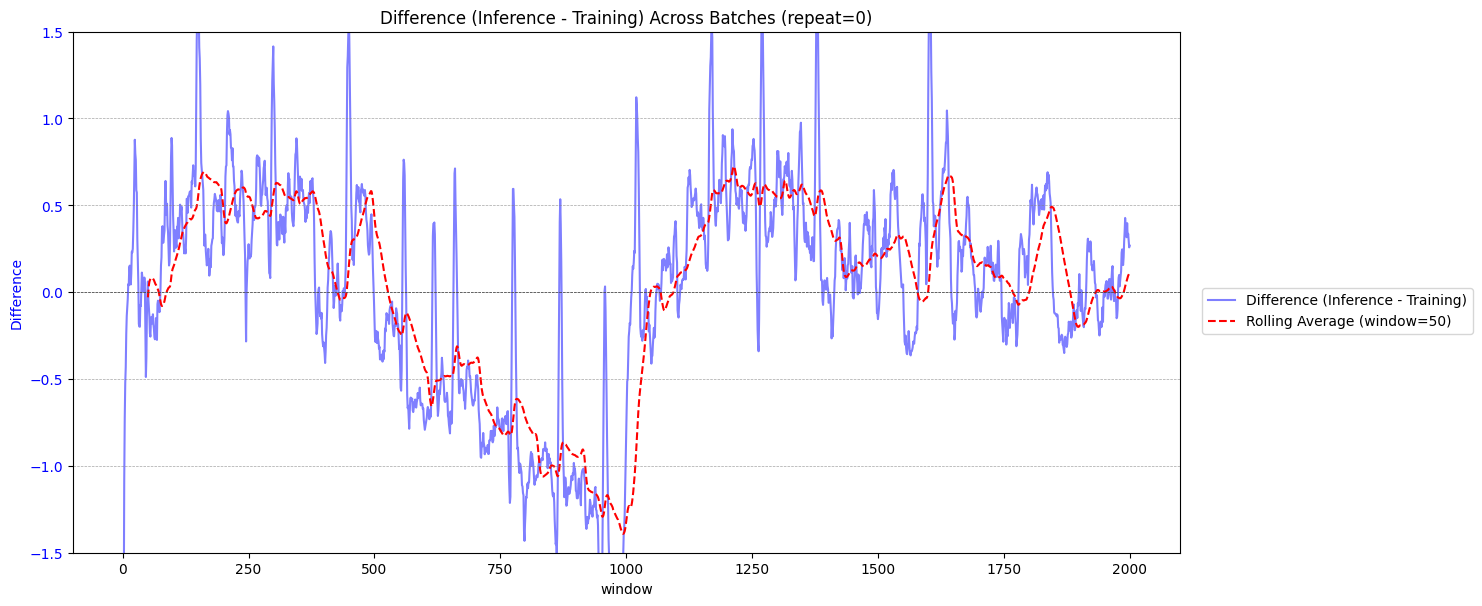

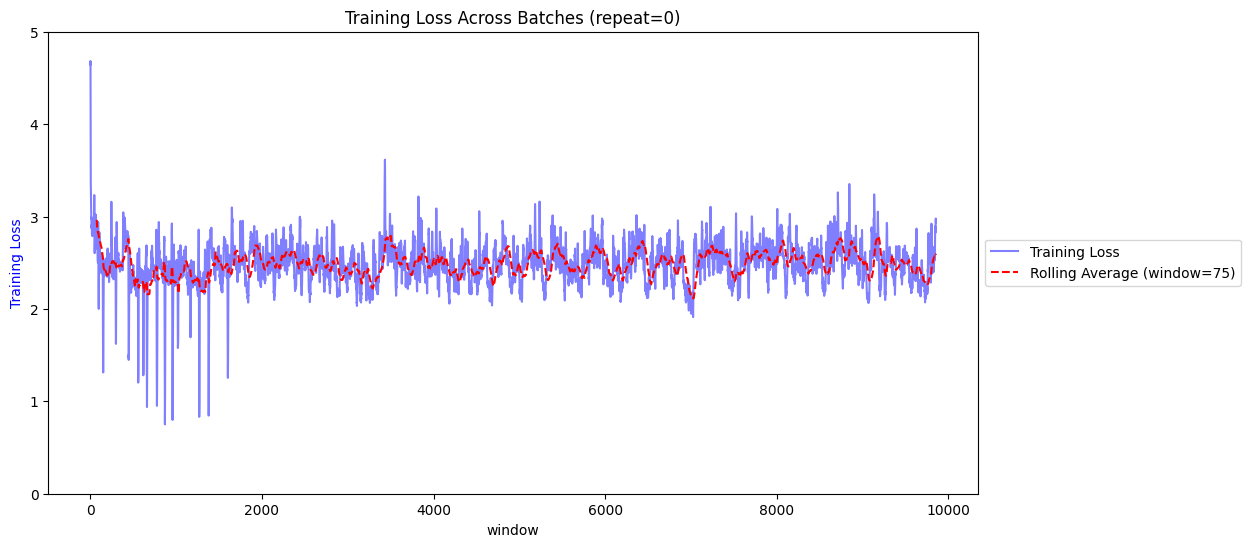

Analysis completed. Plots saved in: experiments/rolling_window_1/retrain_8000_8500


In [23]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_config(config_path):
    with open(config_path, 'r') as cfg_file:
        return json.load(cfg_file)

def plot_difference(training_results, inference_results, save_dir, rolling_window, max_y_diff, repeat_value):
    df_train = pd.DataFrame(training_results)
    df_infer = pd.DataFrame(inference_results)

    # Calculate differences and rolling average
    differences = df_infer['inference_loss'] - df_train['loss']
    rolling_avg_diff = differences.rolling(window=rolling_window).mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting the differences and rolling average
    ax1.plot(df_train['window'], differences, label='Difference (Inference - Training)', color='blue', alpha=0.5)
    ax1.plot(df_train['window'], rolling_avg_diff, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero

    # Add horizontal lines for each y-axis tick mark
    for y in ax1.get_yticks():
        ax1.axhline(y, color='gray', linewidth=0.5, linestyle='--', alpha=0.7)

    ax1.set_xlabel('window')
    ax1.set_ylabel('Difference', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(-max_y_diff, max_y_diff)  # Set y-axis limits for differences

    fig.tight_layout()
    plt.title(f'Difference (Inference - Training) Across Batches (repeat={repeat_value})')
    
    # Move the legend to the right of the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'difference_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def plot_training_loss(training_results, save_dir, rolling_window, max_y_diff, repeat_value):
    df_train = pd.DataFrame(training_results)
    
    # Calculate rolling average of training loss
    rolling_avg_train_loss = df_train['loss'].rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_train['window'], df_train['loss'], label='Training Loss', color='blue', alpha=0.5)
    plt.plot(df_train['window'], rolling_avg_train_loss, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero
    plt.xlabel('window')
    plt.ylabel('Training Loss', color='blue')
    plt.ylim(0, max_y_diff)  # Set maximum y-axis value for training loss
    plt.title(f'Training Loss Across Batches (repeat={repeat_value})')
    
    # Move the legend to the right of the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'training_loss_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def main():
    config_path = 'rolling_window_config.json'
    cfg = load_config(config_path)
    experiment_name = cfg['experiment_name']
    experiment_dir = os.path.join('experiments', experiment_name)
    retrain_dir = os.path.join(experiment_dir, 'retrain_8000_8500')

    results_path = os.path.join(experiment_dir, "training_loss.csv")
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results CSV file not found at {results_path}")

    inference_results_path = os.path.join(retrain_dir, "retrained_inference_results.csv")
    if not os.path.exists(inference_results_path):
        raise FileNotFoundError(f"Inference results CSV file not found at {inference_results_path}")

    # Load and filter training results to include only rows where repeat == 4
    repeat_value = 0
    training_results = pd.read_csv(results_path)
    #training_results = training_results[training_results['repeat'] == repeat_value].to_dict(orient='records')

    inference_results = pd.read_csv(inference_results_path).to_dict(orient='records')

    rolling_window_abs = cfg.get('rolling_window_abs', 50)  # default to 50 if not specified in config
    rolling_window_train = cfg.get('rolling_window_train', 75)  # default to 75 if not specified in config
    max_y_diff_abs = cfg.get('max_y_diff_abs', 1.5)  # default to 0.2 if not specified in config
    max_y_diff_train = cfg.get('max_y_diff_train', 5)  # default to 0.5 if not specified in config

    print(f"Filtered training results length: {len(training_results)}")
    print(f"Inference results length: {len(inference_results)}")

    plot_difference(training_results, inference_results, retrain_dir, rolling_window_abs, max_y_diff_abs, repeat_value)
    plot_training_loss(training_results, retrain_dir, rolling_window_train, max_y_diff_train, repeat_value)

    print(f"Analysis completed. Plots saved in: {retrain_dir}")

if __name__ == "__main__":
    main()


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_config(config_path):
    with open(config_path, 'r') as cfg_file:
        return json.load(cfg_file)

def plot_difference(training_results, inference_results, save_dir, rolling_window, max_y_diff, repeat_value):
    df_train = pd.DataFrame(training_results)
    df_infer = pd.DataFrame(inference_results)

    # Calculate differences and rolling average
    differences = df_infer['inference_loss'] - df_train['train_loss']
    rolling_avg_diff = differences.rolling(window=rolling_window).mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting the differences and rolling average
    ax1.plot(df_train['batch'], differences, label='Difference (Inference - Training)', color='blue', alpha=0.5)
    ax1.plot(df_train['batch'], rolling_avg_diff, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Difference', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(-max_y_diff, max_y_diff)  # Set y-axis limits for differences

    fig.tight_layout()
    plt.title(f'Difference (Inference - Training) Across Batches (repeat={repeat_value})')
    
    # Move the legend to the right of the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'difference_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def plot_training_loss(training_results, save_dir, rolling_window, max_y_diff, repeat_value):
    df_train = pd.DataFrame(training_results)
    
    # Calculate rolling average of training loss
    rolling_avg_train_loss = df_train['train_loss'].rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_train['batch'], df_train['train_loss'], label='Training Loss', color='blue', alpha=0.5)
    plt.plot(df_train['batch'], rolling_avg_train_loss, label=f'Rolling Average (window={rolling_window})', linestyle='--', color='red')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add horizontal line at zero
    plt.xlabel('Batch')
    plt.ylabel('Training Loss', color='blue')
    plt.ylim(0, max_y_diff)  # Set maximum y-axis value for training loss
    plt.title(f'Training Loss Across Batches (repeat={repeat_value})')
    
    # Move the legend to the right of the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig(os.path.join(save_dir, 'training_loss_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()

def main():
    config_path = 'config.json'
    cfg = load_config(config_path)
    experiment_name = cfg['experiment_name']
    experiment_dir = os.path.join('experiments', experiment_name)

    results_path = os.path.join(experiment_dir, "batch_training_results.csv")
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results CSV file not found at {results_path}")

    inference_results_path = os.path.join(experiment_dir, "new_inference_results.csv")
    if not os.path.exists(inference_results_path):
        raise FileNotFoundError(f"Inference results CSV file not found at {inference_results_path}")

    # Load and filter training results to include only rows where repeat == 4
    repeat_value = 0
    training_results = pd.read_csv(results_path)
    #training_results = training_results[training_results['repeat'] == repeat_value].to_dict(orient='records')

    inference_results = pd.read_csv(inference_results_path).to_dict(orient='records')

    rolling_window_abs = cfg.get('rolling_window_abs', 500)  # default to 50 if not specified in config
    rolling_window_train = cfg.get('rolling_window_train', 75)  # default to 75 if not specified in config
    max_y_diff_abs = cfg.get('max_y_diff_abs', 0.03)  # default to 0.2 if not specified in config
    max_y_diff_train = cfg.get('max_y_diff_train', 0.5)  # default to 0.5 if not specified in config

    print(f"Filtered training results length: {len(training_results)}")
    print(f"Inference results length: {len(inference_results)}")

    plot_difference(training_results, inference_results, experiment_dir, rolling_window_abs, max_y_diff_abs, repeat_value)
    plot_training_loss(training_results, experiment_dir, rolling_window_train, max_y_diff_train, repeat_value)

    print(f"Analysis completed. Plots saved in: {experiment_dir}")

if __name__ == "__main__":
    main()


Filtered training results length: 3285
Inference results length: 3285


KeyError: 'train_loss'

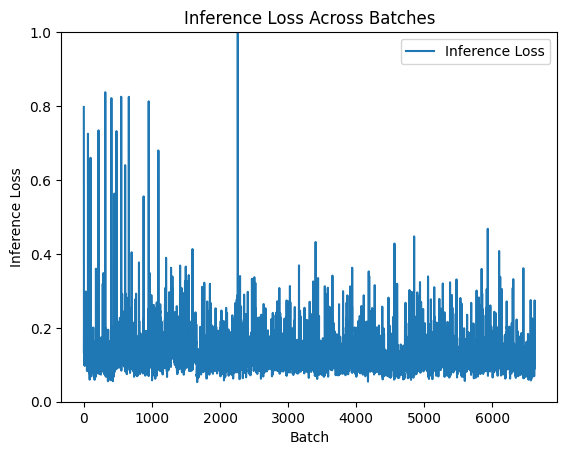

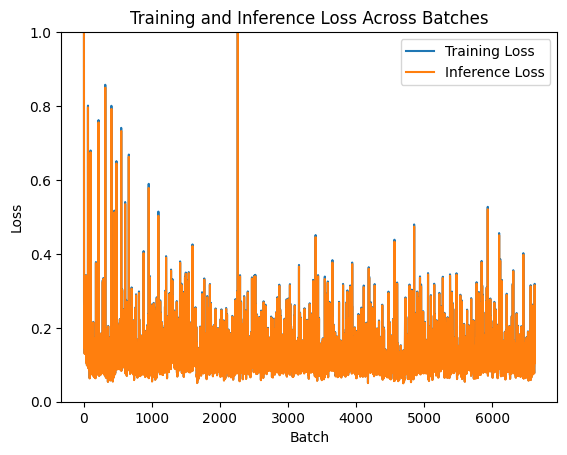

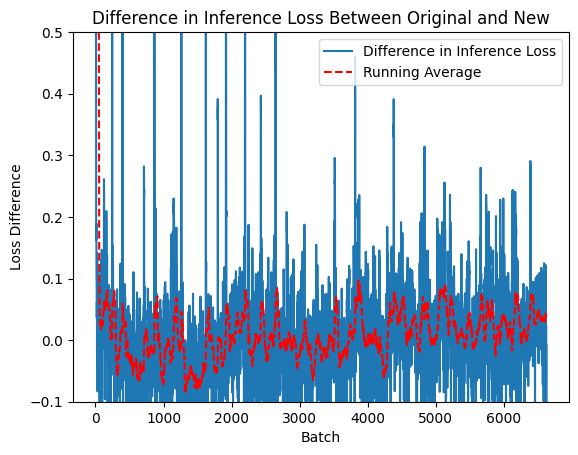

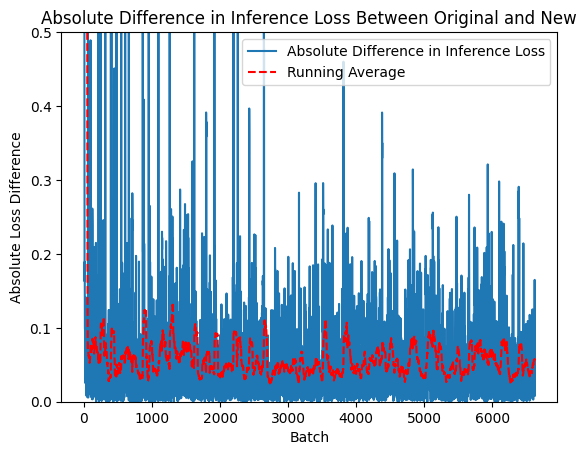

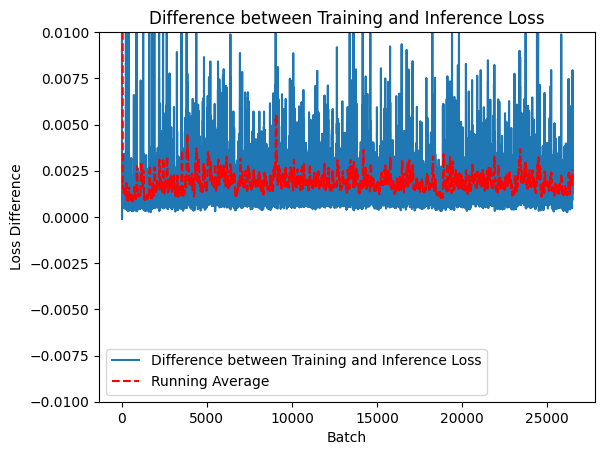

Analysis completed. Plots saved in: experiments/4_epochs_per_batch_DnD_seq


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

def load_config(config_path):
    with open(config_path, 'r') as cfg_file:
        return json.load(cfg_file)

def plot_inference_loss(all_inference_losses, save_dir):
    plt.figure()
    plt.plot(all_inference_losses, label='Inference Loss')
    plt.xlabel('Batch')
    plt.ylabel('Inference Loss')
    plt.title('Inference Loss Across Batches')
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'inference_loss_plot.png'))
    plt.show()
    plt.close()

def plot_training_and_inference_loss(results, save_dir):
    df = pd.DataFrame(results)
    plt.figure()
    plt.plot(df['batch'], df['train_loss'], label='Training Loss')
    plt.plot(df['batch'], df['inference_loss'], label='Inference Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training and Inference Loss Across Batches')
    plt.ylim(0, 1)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'training_inference_loss_plot.png'))
    plt.show()
    plt.close()

def plot_inference_loss_difference(original_losses, new_losses, save_dir):
    differences = [orig - new for orig, new in zip(original_losses, new_losses)]
    running_avg_diff = pd.Series(differences).rolling(window=50).mean()
    abs_differences = [abs(diff) for diff in differences]
    running_avg_abs_diff = pd.Series(abs_differences).rolling(window=50).mean()
    
    # Difference Plot
    plt.figure()
    plt.plot(differences, label='Difference in Inference Loss')
    plt.plot(running_avg_diff, label='Running Average', linestyle='--', color='red')
    plt.xlabel('Batch')
    plt.ylabel('Loss Difference')
    plt.title('Difference in Inference Loss Between Original and New')
    plt.ylim(-0.1, 0.5)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'inference_loss_difference_plot.png'))
    plt.show()
    plt.close()

    # Absolute Difference Plot
    plt.figure()
    plt.plot(abs_differences, label='Absolute Difference in Inference Loss')
    plt.plot(running_avg_abs_diff, label='Running Average', linestyle='--', color='red')
    plt.xlabel('Batch')
    plt.ylabel('Absolute Loss Difference')
    plt.title('Absolute Difference in Inference Loss Between Original and New')
    plt.ylim(0, 0.5)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'inference_loss_abs_difference_plot.png'))
    plt.show()
    plt.close()

def plot_training_inference_loss_difference(results, save_dir):
    df = pd.DataFrame(results)
    differences = df['train_loss'] - df['inference_loss']
    running_avg_diff = differences.rolling(window=50).mean()
    
    plt.figure()
    plt.plot(differences, label='Difference between Training and Inference Loss')
    plt.plot(running_avg_diff, label='Running Average', linestyle='--', color='red')
    plt.xlabel('Batch')
    plt.ylabel('Loss Difference')
    plt.title('Difference between Training and Inference Loss')
    plt.ylim(-0.01, 0.01)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'training_inference_loss_difference_plot.png'))
    plt.show()
    plt.close()

def main():
    config_path = 'config.json'
    cfg = load_config(config_path)
    experiment_name = cfg['experiment_name']
    experiment_dir = os.path.join('experiments', experiment_name)

    results_path = os.path.join(experiment_dir, "batch_training_results.csv")
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results CSV file not found at {results_path}")

    results = pd.read_csv(results_path).to_dict(orient='records')

    inference_results_path = os.path.join(experiment_dir, "new_inference_results.csv")
    if not os.path.exists(inference_results_path):
        raise FileNotFoundError(f"Inference results CSV file not found at {inference_results_path}")

    new_inference_results = pd.read_csv(inference_results_path).to_dict(orient='records')
    all_inference_losses = [result['inference_loss'] for result in new_inference_results]

    plot_inference_loss(all_inference_losses, experiment_dir)
    plot_training_and_inference_loss(results, experiment_dir)

    original_inference_losses = [result['inference_loss'] for result in results]
    plot_inference_loss_difference(original_inference_losses, all_inference_losses, experiment_dir)
    plot_training_inference_loss_difference(results, experiment_dir)

    print(f"Analysis completed. Plots saved in: {experiment_dir}")

if __name__ == "__main__":
    main()
